In [1]:
import mindspore
# 载入mindspore的默认数据集
import mindspore.dataset as ds
# 常用转化用算子
import mindspore.dataset.transforms.c_transforms as C
# 图像转化用算子
####____####
import mindspore.dataset.vision.c_transforms as CV
from mindspore.common import dtype as mstype
# mindspore的tensor
from mindspore import Tensor


# 各类网络层都在nn里面
import mindspore.nn as nn
# 参数初始化的方式

from mindspore.common.initializer import TruncatedNormal
# 设置mindspore运行的环境
from mindspore import context
# 引入训练时候会使用到回调函数，如checkpoint, lossMoniter
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
# 引入模型
from mindspore.train import Model
# 引入评估模型的包
from mindspore.nn.metrics import Accuracy

# numpy
import numpy as np
# 画图用
import matplotlib.pyplot as plt


####____####
# 下载数据相关的包
import os
import requests 
import zipfile

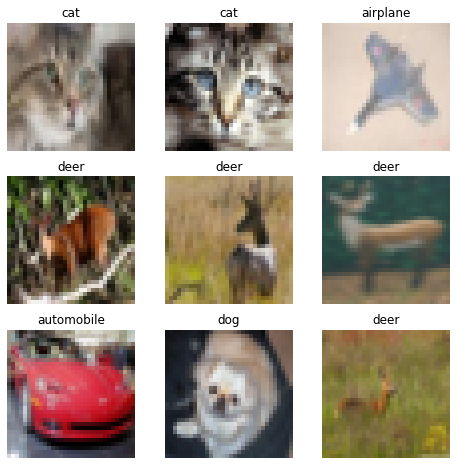

In [2]:
#创建图像标签列表
category_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',
                 6:'frog',7:'horse',8:'ship',9:'truck'}

####____####
current_path = os.getcwd()
data_path = os.path.join(current_path, 'data/10-verify-bin')
cifar_ds = ds.Cifar10Dataset(data_path)

# 设置图像大小
plt.figure(figsize=(8,8))
i = 1
# 打印9张子图
for dic in cifar_ds.create_dict_iterator():
    plt.subplot(3,3,i)
    ####____####
    plt.imshow(dic['image'].asnumpy())
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(category_dict[dic['label'].asnumpy().sum()])
    i +=1
    if i > 9 :
        break

plt.show()

In [3]:
def get_data(datapath):
    cifar_ds = ds.Cifar10Dataset(datapath)
    return cifar_ds

def process_dataset(cifar_ds,batch_size =32,status="train"):
    '''
    ---- 定义算子 ----
    '''
    # 归一化
    rescale = 1.0 / 255.0
    # 平移
    shift = 0.0

    resize_op = CV.Resize((32, 32))
    rescale_op = CV.Rescale(rescale, shift)
    # 对于RGB三通道分别设定mean和std
    normalize_op = CV.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    if status == "train":
        # 随机裁剪
        random_crop_op = CV.RandomCrop([32, 32], [4, 4, 4, 4])
        # 随机翻转
        random_horizontal_op = CV.RandomHorizontalFlip()
    # 通道变化
    channel_swap_op = CV.HWC2CHW()
    # 类型变化
    typecast_op = C.TypeCast(mstype.int32)

    '''
    ---- 算子运算 ----
    '''
    cifar_ds = cifar_ds.map(input_columns="label", operations=typecast_op)
    if status == "train":
        cifar_ds = cifar_ds.map(input_columns="image", operations=random_crop_op)
        cifar_ds = cifar_ds.map(input_columns="image", operations=random_horizontal_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=resize_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=rescale_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=normalize_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=channel_swap_op)
    
    # shuffle
    cifar_ds = cifar_ds.shuffle(buffer_size=1000)
    # 切分数据集到batch_size
    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)
    
    return cifar_ds



In [4]:
data_path = os.path.join(current_path, 'data/10-batches-bin')
batch_size=32
status="train"

# 生成训练数据集
cifar_ds = get_data(data_path)
ds_train = process_dataset(cifar_ds,batch_size =batch_size, status=status)

In [5]:
import resnet

network = resnet.resnet18(class_num=10)

In [6]:
# 返回当前设备
device_target = mindspore.context.get_context('device_target')
# 确定图模型是否下沉到芯片上
dataset_sink_mode = True if device_target in ['Ascend','GPU'] else False
# 设置模型的设备与图的模式
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)
# 使用交叉熵函数作为损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
# 优化器为Adam
net_opt = nn.Adam(params=network.trainable_params(), learning_rate=0.001)
# 监控每个epoch训练的时间
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())

In [7]:
from mindspore.train.callback import Callback

class EvalCallBack(Callback):
    def __init__(self, model, eval_dataset, eval_per_epoch, epoch_per_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.eval_per_epoch = eval_per_epoch
        self.epoch_per_eval = epoch_per_eval

    def epoch_end(self, run_context):
        cb_param = run_context.original_args()
        cur_epoch = cb_param.cur_epoch_num
        if cur_epoch % self.eval_per_epoch == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.epoch_per_eval["epoch"].append(cur_epoch)
            self.epoch_per_eval["acc"].append(acc["Accuracy"])
            print(acc)

In [ ]:
# 设置CheckpointConfig，callback函数。save_checkpoint_steps=训练总数/batch_size
config_ck = CheckpointConfig(save_checkpoint_steps=1562,
                             keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet_original", directory='./results',config=config_ck)
# 建立可训练模型
model = Model(network = network, loss_fn=net_loss,optimizer=net_opt, metrics={"Accuracy": Accuracy()})
eval_per_epoch = 1
epoch_per_eval = {"epoch": [], "acc": []}
eval_cb = EvalCallBack(model, ds_train, eval_per_epoch, epoch_per_eval)
print("============== Starting Training ==============")
model.train(100, ds_train,callbacks=[ckpoint_cb, LossMonitor(per_print_times=1),eval_cb],dataset_sink_mode=dataset_sink_mode)

============== Starting Training ==============
epoch: 1 step: 1562, loss is 1.3497357
{'Accuracy': 0.5158050576184379}
epoch: 2 step: 1562, loss is 1.0672209
{'Accuracy': 0.6112155889884763}
epoch: 3 step: 1562, loss is 1.1848596
{'Accuracy': 0.6517485595390525}
epoch: 4 step: 1562, loss is 0.8696519
{'Accuracy': 0.6986435659411011}
epoch: 5 step: 1562, loss is 1.1248665
{'Accuracy': 0.7129081306017926}
epoch: 6 step: 1562, loss is 0.6076118
{'Accuracy': 0.7532210307298336}
epoch: 7 step: 1562, loss is 0.89642256
{'Accuracy': 0.749939980793854}
epoch: 8 step: 1562, loss is 0.9444308
{'Accuracy': 0.7740877080665813}
epoch: 9 step: 1562, loss is 0.53481126
{'Accuracy': 0.7696062740076824}
epoch: 10 step: 1562, loss is 0.5490536
{'Accuracy': 0.7978353072983355}
epoch: 11 step: 1562, loss is 0.78010994
{'Accuracy': 0.8004161331626121}
epoch: 12 step: 1562, loss is 0.92211896
{'Accuracy': 0.8066381241997439}
epoch: 13 step: 1562, loss is 0.43870527
{'Accuracy': 0.8179417413572343}
epoch: 1